In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.examples.tutorials.mnist import input_data
from pylab import imshow

In [3]:
# xavier 参数初始化方法， 让权重满足均值为 0，同时方差为 2/(n_in + n_out)
def xavier_init(n_in, n_out, constant=1):
    low = -constant * np.sqrt(6.0 / n_in + n_out)
    high = -low
    return tf.random_uniform(shape=(n_in, n_out), minval=low, maxval=high, dtype=tf.float32)

In [4]:
class AdditiveGaussianAutoEncoder():
    def __init__(self, 
                 n_input,                            # 输入变量数（特征数）
                 n_hidden,                           # 隐含层节点数（这里默认只有一个隐含层）
                 transfer_function=tf.nn.softplus,   # 隐层激活函数： softplus
                 optimizer=tf.train.AdamOptimizer,   # Adam优化器
                 noise_scale=0.01):                  # 高斯噪声系数
        self.n_input = n_input
        self.n_output = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder(dtype=tf.float32)  # 噪声变量占位
        self.noise_scale = noise_scale
        self.weights = self._initialize_weights()
        
        # 按照 Andrew Ng建议的方式，行为特征， 列为样本
        self.X = tf.placeholder(dtype=tf.float32, shape=[self.n_input, None])
        # 隐藏层的输出  shape: n_hidden * m
        self.hidden = self.transfer(
            tf.add(
                # w1: n_hidden * n_input
                # x: n_input * m
                # b1: n_hidden * 1 -> broadcast
                # 并传入一个噪声占位变量
                self.weights['w1'] @ (self.X + self.scale * tf.random_normal(shape=[self.n_input, 1])),
                self.weights['b1']
            )
        )
        # 基于隐藏层输出的重构样本 shape: n_output * m == n_input * m (X)
        self.reconstruction = tf.add(
            # w2: n_output * n_hidden
            # hidden: n_hidden * m
            # b2: n_output * 1 -> broadcast
            self.weights['w2'] @ self.hidden,
            self.weights['b2']
        )
        # 使用和方差（SSE: sum of squared error）作为损失函数，向量的重构损失函数
        self.cost = 0.5 * tf.reduce_sum(
            tf.pow(tf.subtract(self.reconstruction, self.X), 2.0)
        )
        
        self.optimizer = optimizer.minimize(self.cost)
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
    
    # NN网络的初始参数生成器 xavier initializer
    def xavier_init(self, n_in, n_out, constant=1):
        low = -constant * np.sqrt(6.0 / (n_in + n_out))
        high = -low
        return tf.random_uniform(shape=(n_out, n_in), minval=low, maxval=high, dtype=tf.float32)
    
    # 参数初始化函数
    def _initialize_weights(self):
        all_weights = {}
        # shape: n_hidden * n_input
        all_weights["w1"] = tf.Variable(self.xavier_init(self.n_input, self.n_hidden))
        # shape: n_hidden * 1
        all_weights["b1"] = tf.Variable(tf.zeros([self.n_hidden, 1]), dtype=tf.float32)
        # shape: n_output(n_input) * n_hidden
        all_weights["w2"] = tf.Variable(tf.zeros([self.n_output, self.n_hidden]), dtype=tf.float32)
        # shape: n_output * 1
        all_weights["b2"] = tf.Variable(tf.zeros([self.n_output, 1], dtype=tf.float32))
        return all_weights
    
    # 1. 基础训练、衡量功能
    ## 1.1. 传入一个batch数据后，做优化和计算损失函数，用于训练集
    def partial_fit(self, X):
        holder_dict = {self.X: X, self.scale: self.noise_scale}
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict=holder_dict)
        return cost
    
    ## 1.2. 传入一个batch数据后，只做损失函数的计算，应用于测试集
    def calc_total_cost(self, X):
        holder_dict = {self.X: X, self.scale: self.noise_scale}
        cost = self.sess.run(self.cost, feed_dict=holder_dict)
        return cost
    
    # 2. 自解码器预测功能解耦
    ## 2.0. 完整功能  输入原始数据 -> 返回重构数据
    def reconstruct(self, X):
        holder_dict = {self.X: X, self.scale: self.noise_scale}
        reconstruction = self.sess.run(self.reconstruction, feed_dict=holder_dict)
        return reconstruction    

    ## 2.1. 输入原始数据 -> 返回隐含层的输出结果（高阶特征）
    def transform(self, X):
        holder_dict = {self.X: X, self.scale: self.noise_scale}
        hidden = self.sess.run(self.hidden, feed_dict=holder_dict)
        return hidden
    
    ## 2.2. 输入隐含层结果（高阶特征）-> 返回根据高阶特征重构的原数据
    def generate(self, hidden=None):
        if hidden is None:
            hidden = np.random.normal(size=self.weights["b1"].shape)
        holder_dict = {self.hidden: hidden}
        reconstruction = self.sess.run(self.reconstruction, feed_dict=holder_dict)
        return reconstruction
    
    # 3. 参数输出功能，即高阶特征的生成公式
    ## 3.1. 隐含层的权重系数
    def getWeights(self):
        return self.weights["w1"]
    ## 3.2. 隐含层的偏置系数
    def getBias(self):
        return self.weights["b1"]  
    

In [5]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [6]:
def standarize(X_train, X_test):
    ss = StandardScaler(with_mean=0, with_std=1)
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)
    return X_train, X_test
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index : (start_index + batch_size)]

In [7]:
X_train, X_test = standarize(mnist.train.images, mnist.test.images)

In [8]:
n_samples = int(mnist.train.num_examples)  # 55000
training_epochs = 50
batch_size = 128
batch_num = int(n_samples / batch_size)
display_step = 1  # 决定每多少步输出一次结果

In [9]:
autoencoder = AdditiveGaussianAutoEncoder(n_input= 784, 
                                          n_hidden=200, 
                                          transfer_function=tf.nn.softplus, 
                                          optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
                                          noise_scale=0.01)

In [10]:
train_cost_list = []
test_cost_list = []
for epoch in range(training_epochs):
    avg_cost = 0
    batch_num = int(n_samples / batch_size)
    for i in range(batch_num):
        batch_xs = get_random_block_from_data(X_train, batch_size)
        cost = autoencoder.partial_fit(batch_xs.T)
        avg_cost += (cost * batch_size / n_samples)
    
    train_cost_list.append(avg_cost)
    test_cost = autoencoder.calc_total_cost(X_test.T)
    test_cost_list.append(test_cost)
    if epoch % display_step == 0:
        print("Epoch: %04d , training_cost: %.3f, test_cost: %.3f" % 
              (epoch + 1, avg_cost, test_cost))

Epoch: 0001 , training_cost: 20056.262, test_cost: 1025185.688
Epoch: 0002 , training_cost: 11758.185, test_cost: 844657.312
Epoch: 0003 , training_cost: 9365.140, test_cost: 793089.875
Epoch: 0004 , training_cost: 9368.041, test_cost: 784736.688
Epoch: 0005 , training_cost: 8113.233, test_cost: 722504.250
Epoch: 0006 , training_cost: 8892.091, test_cost: 780877.375
Epoch: 0007 , training_cost: 7773.509, test_cost: 719210.375
Epoch: 0008 , training_cost: 7534.802, test_cost: 711455.000
Epoch: 0009 , training_cost: 8020.913, test_cost: 769241.875
Epoch: 0010 , training_cost: 8608.807, test_cost: 768699.375
Epoch: 0011 , training_cost: 8185.320, test_cost: 703589.375
Epoch: 0012 , training_cost: 7446.985, test_cost: 702726.000
Epoch: 0013 , training_cost: 8081.648, test_cost: 712006.188
Epoch: 0014 , training_cost: 8006.126, test_cost: 710470.625
Epoch: 0015 , training_cost: 8128.846, test_cost: 694850.000
Epoch: 0016 , training_cost: 7216.261, test_cost: 738882.500
Epoch: 0017 , trainin

In [11]:
a = X_test[1, ].reshape(1, -1)

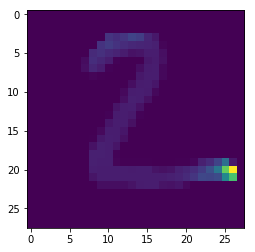

In [12]:
imshow(a.reshape(28, 28))
plt.show()

In [13]:
ar = autoencoder.reconstruct(a.T)

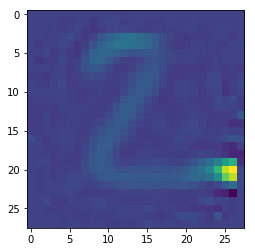

In [14]:
imshow(ar.reshape(28, 28))
plt.show()

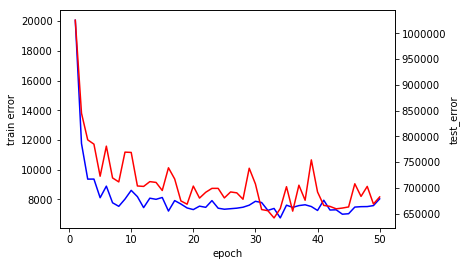

In [15]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
epochs = list(range(1, training_epochs + 1))
ax1.plot(epochs, train_cost_list, 'b')
ax1.set_xlabel("epoch")
ax1.set_ylabel("train error")
ax2.plot(epochs, test_cost_list, 'r')
ax2.set_ylabel("test_error")
plt.show()

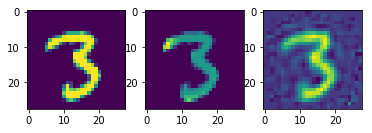

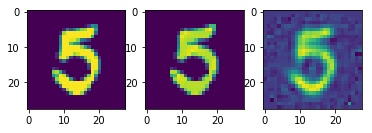

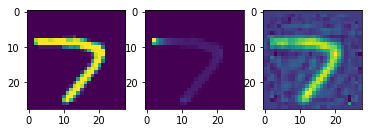

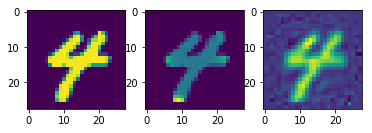

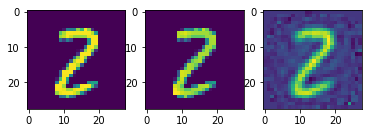

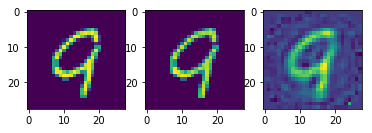

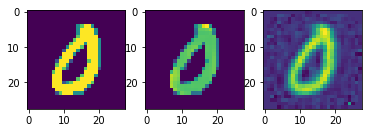

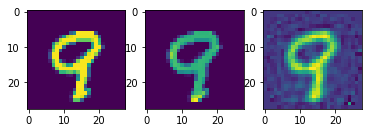

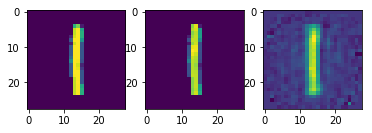

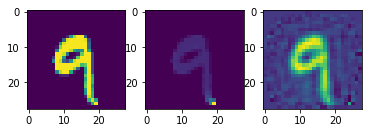

In [16]:
i = 0
n_test_samples = int(mnist.test.num_examples)
while i < 10:
    index = np.random.randint(0, n_test_samples)
    original = mnist.test.images[index, ].reshape(1, -1)
    standard = X_test[index, ].reshape(1, -1)
    reconstruction = autoencoder.reconstruct(original.T)
    
    plt.subplot(1, 3, 1)
    imshow(original.reshape(28, 28))
    plt.subplot(1, 3, 2)
    imshow(standard.reshape(28, 28))
    plt.subplot(1, 3, 3)
    imshow(reconstruction.reshape(28, 28))
    plt.show()
    i += 1 